In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
interim_dir = "../data/interim"
processed_dir = "../data/processed"

data_model_file = os.path.join(processed_dir, "data_model_output.csv")

In [3]:
data_model_df = pd.read_csv(data_model_file)
data_model_df.head()
data_model_df = data_model_df[(data_model_df['is_completed'] == 1) & (data_model_df['record_type_synthetic'] == 0) & (data_model_df['submit']==True)]

C:\Users\USVV724227\AppData\Local\Temp\ipykernel_38900\2793295500.py:1: DtypeWarning: Columns (1,4,12,13,14,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,46,47,53,54,58,64,69,73,76,77,79,81,82,85,91,92,94,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,131,137,139,141,148,149,150,153,154,155,160,165,167,175,177,183,192,193,194,197,202,206,207,212,214,215,218,219,235,237,238,239,240,241,242,244,246,247,248,249,250,260,261,266,271,279,280,281,284,287,291,292,293,295,296,315,329,331,333,334,336,348,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,398,402,404,407,408,409,431,432) have mixed types. Specify dtype option on import or set low_memory=False.
  data_model_df = pd.read_csv(data_model_file)


In [4]:
working_df = data_model_df[['respondentid', 'marketsegment_label', 'passenger_type_label', 'main_mode_label', 'access_mode_label', 
                            'egress_mode_label', 'origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude', 'transit_boarding_latitude', 'transit_boarding_longitude',
                            'transit_alighting_latitude', 'transit_alighting_longitude']]

In [5]:
working_df.head()

,respondentid,marketsegment_label,passenger_type_label,main_mode_label,access_mode_label,egress_mode_label,origin_latitude,origin_longitude,destination_latitude,destination_longitude,transit_boarding_latitude,transit_boarding_longitude,transit_alighting_latitude,transit_alighting_longitude
0,5473,EMPLOYEE,NaN,DROVE_ALONE_AND_PARKED,NaN,NaN,32.816714,-117.176898,32.732627,-117.204064,NaN,NaN,NaN,NaN
1,5476,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.639943,-117.085774,32.733783,-117.193315,32.638845,-117.099066,32.732133,-117.197756
2,5489,EMPLOYEE,NaN,DROVE_ALONE_AND_PARKED,NaN,NaN,32.743009,-117.131699,32.732627,-117.204064,NaN,NaN,NaN,NaN
3,5558,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.706752,-117.148810,32.732627,-117.204064,32.715832,-117.154063,32.731419,-117.203010
4,5593,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.678108,-117.099196,32.732627,-117.204064,32.674640,-117.113186,32.731419,-117.203010


In [6]:
len(working_df)

3768

In [7]:
working_df = working_df[
    working_df[['transit_boarding_latitude', 'transit_boarding_longitude',
                'transit_alighting_latitude', 'transit_alighting_longitude',
                'origin_latitude', 'origin_longitude',
                'destination_latitude', 'destination_longitude']].notna().all(axis=1)
]


In [8]:
working_df.head()

,respondentid,marketsegment_label,passenger_type_label,main_mode_label,access_mode_label,egress_mode_label,origin_latitude,origin_longitude,destination_latitude,destination_longitude,transit_boarding_latitude,transit_boarding_longitude,transit_alighting_latitude,transit_alighting_longitude
1,5476,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.639943,-117.085774,32.733783,-117.193315,32.638845,-117.099066,32.732133,-117.197756
3,5558,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.706752,-117.148810,32.732627,-117.204064,32.715832,-117.154063,32.731419,-117.203010
4,5593,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.678108,-117.099196,32.732627,-117.204064,32.674640,-117.113186,32.731419,-117.203010
6,5613,EMPLOYEE,NaN,AIRPORT_FLYER_SHUTTLE,WALK,NaN,32.755747,-117.197638,32.732627,-117.204064,32.755309,-117.199526,32.731527,-117.202270
7,5622,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.690364,-117.174227,32.733783,-117.193315,32.691773,-117.176137,32.732133,-117.197756


In [9]:
len(working_df)

324

In [10]:
working_df['access_mode_label'].value_counts()

access_mode_label
WALK                                    141
DROVE_ALONE_AND_PARKED                   64
DROPPED_OFF_BY_FAMILY_FRIEND             44
UBER_LYFT                                13
DROVE_WITH_OTHERS_AND_PARKED              6
OTHER                                     5
CAR_SERVICE_BLACK_LIMO                    3
OTHER_PUBLIC_TRANSIT                      3
RODE_WITH_OTHER_TRAVELERS_AND_PARKED      3
TAXI                                      1
Name: count, dtype: int64

In [11]:
from geopy.distance import geodesic

# Filtering departing passengers and calculating distance between transit_boarding and origin
working_df.loc[(working_df['passenger_type_label'] == 'DEPARTING') | (working_df['marketsegment_label'] == 'EMPLOYEE'), 'distance'] = working_df.apply(
    lambda row: geodesic(
        (row['origin_latitude'], row['origin_longitude']), 
        (row['transit_boarding_latitude'], row['transit_boarding_longitude'])
    ).miles, axis=1
)

# Filtering arriving passengers and calculating distance between transit_alighting and destination
working_df.loc[working_df['passenger_type_label'] == 'ARRIVING', 'distance'] = working_df.apply(
    lambda row: geodesic(
        (row['destination_latitude'], row['destination_longitude']), 
        (row['transit_alighting_latitude'], row['transit_alighting_longitude'])
    ).miles, axis=1
)

In [12]:
working_df['distance']

1       0.778664
3       0.696556
4       0.849660
6       0.114004
7       0.147665
          ...   
4841    0.209948
4890    0.323594
4894    0.224479
4922    0.110242
4931    0.092311
Name: distance, Length: 324, dtype: float64

In [13]:
len(working_df[working_df['distance']<1])

186

In [14]:
distance_less_than_a_mile_df = working_df[working_df['distance']<0.5]
distance_less_than_a_mile_df['access_mode_label'].value_counts()

access_mode_label
WALK                                    102
DROPPED_OFF_BY_FAMILY_FRIEND              7
DROVE_ALONE_AND_PARKED                    2
OTHER                                     2
UBER_LYFT                                 2
OTHER_PUBLIC_TRANSIT                      2
RODE_WITH_OTHER_TRAVELERS_AND_PARKED      2
CAR_SERVICE_BLACK_LIMO                    1
DROVE_WITH_OTHERS_AND_PARKED              1
Name: count, dtype: int64

In [15]:
working_df.head()

,respondentid,marketsegment_label,passenger_type_label,main_mode_label,access_mode_label,egress_mode_label,origin_latitude,origin_longitude,destination_latitude,destination_longitude,transit_boarding_latitude,transit_boarding_longitude,transit_alighting_latitude,transit_alighting_longitude,distance
1,5476,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.639943,-117.085774,32.733783,-117.193315,32.638845,-117.099066,32.732133,-117.197756,0.778664
3,5558,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.706752,-117.148810,32.732627,-117.204064,32.715832,-117.154063,32.731419,-117.203010,0.696556
4,5593,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.678108,-117.099196,32.732627,-117.204064,32.674640,-117.113186,32.731419,-117.203010,0.849660
6,5613,EMPLOYEE,NaN,AIRPORT_FLYER_SHUTTLE,WALK,NaN,32.755747,-117.197638,32.732627,-117.204064,32.755309,-117.199526,32.731527,-117.202270,0.114004
7,5622,EMPLOYEE,NaN,MTS_ROUTE_992,WALK,NaN,32.690364,-117.174227,32.733783,-117.193315,32.691773,-117.176137,32.732133,-117.197756,0.147665


In [16]:
access_mean_distance = working_df.groupby(
    ['marketsegment_label', 'access_mode_label']
).agg(
    avg_distance_miles=('distance', 'mean'),
    num_respondents=('distance', 'count'),
    median_distance = ('distance', 'median')
).reset_index()

access_mean_distance.head(20)

,marketsegment_label,access_mode_label,avg_distance_miles,num_respondents,median_distance
0,EMPLOYEE,DROPPED_OFF_BY_FAMILY_FRIEND,2.419759,16,1.490182
1,EMPLOYEE,DROVE_ALONE_AND_PARKED,3.124687,57,2.269270
2,EMPLOYEE,DROVE_WITH_OTHERS_AND_PARKED,3.244772,1,3.244772
3,EMPLOYEE,UBER_LYFT,1.260110,2,1.260110
4,EMPLOYEE,WALK,0.647290,62,0.348052
5,PASSENGER,CAR_SERVICE_BLACK_LIMO,16.337502,3,5.952953
6,PASSENGER,DROPPED_OFF_BY_FAMILY_FRIEND,6.867432,28,3.287792
7,PASSENGER,DROVE_ALONE_AND_PARKED,19.801088,7,14.447224
8,PASSENGER,DROVE_WITH_OTHERS_AND_PARKED,21.172834,5,2.855851
9,PASSENGER,OTHER,6.897389,5,1.566565


In [17]:
egress_mean_distance = working_df.groupby(
    ['marketsegment_label', 'egress_mode_label']
).agg(
    avg_distance_miles=('distance', 'mean'),
    num_respondents=('distance', 'count'),
    median_distance = ('distance', 'median')
).reset_index()

egress_mean_distance.head(20)

,marketsegment_label,egress_mode_label,avg_distance_miles,num_respondents,median_distance
0,PASSENGER,OTHER_SHARED_VAN,2.452758,1,2.452758
1,PASSENGER,PICKED_UP_BY_FAMILY_FRIEND,2.448307,11,1.330267
2,PASSENGER,TAXI,2.103394,1,2.103394
3,PASSENGER,UBER_LYFT,2.265749,2,2.265749
4,PASSENGER,WALK,0.371253,24,0.243744


In [18]:
def plot_distance_distribution(working_df):
    # Calculate Q1, Q3, and IQR
    Q1 = working_df['distance'].quantile(0.25)
    Q3 = working_df['distance'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the right-sided outlier threshold
    threshold = Q3 + 1.5 * IQR

    print("Right-sided outlier threshold:", threshold)

    # Identify outliers (rows with destination greater than threshold)
    right_outliers = working_df[working_df['distance'] > threshold]
    print("Number of right-sided outliers:", len(right_outliers))

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(working_df['distance'], bins=50, alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2,
                label=f'Outlier Threshold: {threshold:.2f}')
    plt.xlabel('Access/Egress Mode Distance')
    plt.ylabel('Frequency')
    plt.title('Distribution of Access Mode Distance with Right-Sided Outlier Threshold')
    plt.legend()
    plt.show()

Right-sided outlier threshold: 4.978528572411333
Number of right-sided outliers: 35


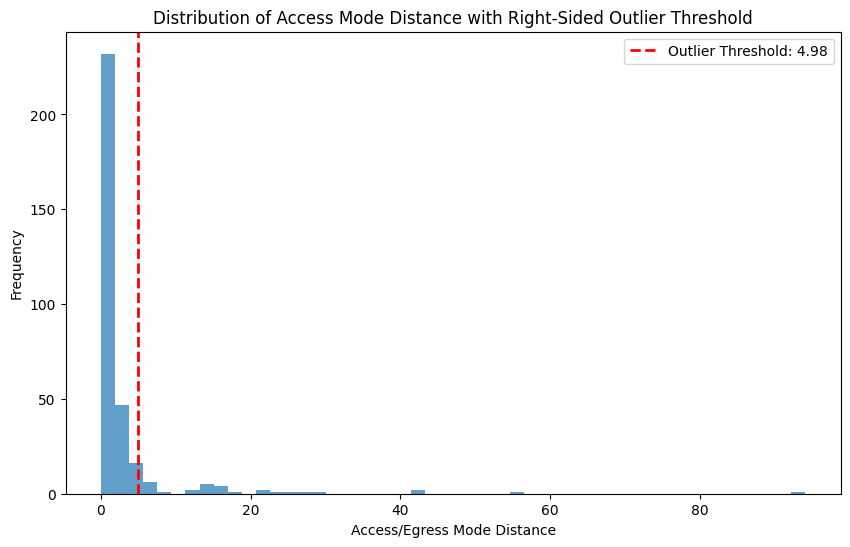

In [19]:
plot_distance_distribution(working_df)

Right-sided outlier threshold: 1.1332413619771522
Number of right-sided outliers: 9


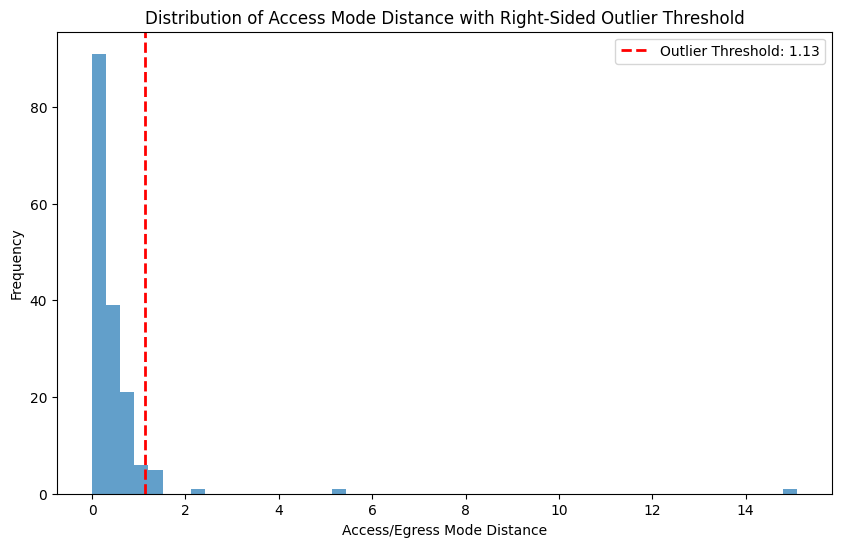

In [20]:
plot_distance_distribution(working_df[(working_df['access_mode_label']=='WALK')|(working_df['egress_mode_label']=='WALK')])

In [21]:
outliers_walk_df = working_df[((working_df['access_mode_label']=='WALK')|(working_df['egress_mode_label']=='WALK')) & (working_df['distance']>1)]

In [22]:
len(outliers_walk_df)

11

In [23]:
outliers_walk_df[['respondentid', 'distance', 'marketsegment_label']].to_csv('../data/processed/access_mode_walk_distance_outliers.csv', index = False)